# Boosted Trees

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_validate

from dataloader import DataLoader
import utils

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_validate
# needed for HistGradientBoostingClassifier
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
# from sklearn.inspection import partial_dependence, plot_partial_dependence
# from sklearn.metrics import roc_auc_score

In [2]:
loandata = DataLoader('data/loan_data_clean.csv',
                           feature_names=['person_income', 'loan_int_rate','loan_percent_income', 'loan_intent'],
                           target_names=['loan_status'])
loandata.train_test_split()

## AdaBoost

As part of its [ensemble module](https://scikit-learn.org/stable/modules/ensemble.html#adaboost), sklearn provides an [AdaBoostClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) implementation that supports two or more classes. The code examples for this section are in the notebook gbm_baseline that compares the performance of various algorithms with a dummy classifier that always predicts the most frequent class.

### Base Estimator

We need to first define a base_estimator as a template for all ensemble members and then configure the ensemble itself. We'll use the default DecisionTreeClassifier with max_depth=1—that is, a stump with a single split. The complexity of the base_estimator is a key tuning parameter because it depends on the nature of the data. Changes to `max_depth` should be combined with appropriate regularization constraints using adjustments to, for example, `min_samples_split`:

In [3]:
base_estimator = DecisionTreeClassifier(criterion='gini', 
                                        splitter='best',
                                        max_depth=1, 
                                        min_samples_split=2, 
                                        min_samples_leaf=20, 
                                        min_weight_fraction_leaf=0.0,
                                        max_features=None, 
                                        random_state=None, 
                                        max_leaf_nodes=None, 
                                        min_impurity_decrease=0.0, 
                                        class_weight=None)

### AdaBoost Configuration

In the second step, we'll design the ensemble. The n_estimators parameter controls the number of weak learners and the learning_rate determines the contribution of each weak learner, as shown in the following code. By default, weak learners are decision tree stumps:

In [4]:
ada = AdaBoostClassifier(estimator=base_estimator,
                         n_estimators=100,
                         learning_rate=1.0,
                         algorithm='SAMME.R',
                         random_state=42)

The main tuning parameters that are responsible for good results are `n_estimators` and the base estimator complexity because the depth of the tree controls the extent of the interaction among the features. 

### Cross-validate

We will cross-validate the AdaBoost ensemble using a 5-fold split to predict the loan status. To run the cross validation we use the `run_cross_validation` which performs the cross validation given a number of metrics and prints out the `catplot` for each one. The metrics must have the following form:

In [5]:
metrics = {'balanced_accuracy': 'Accuracy' ,
           'roc_auc': 'AUC',
           'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
          }

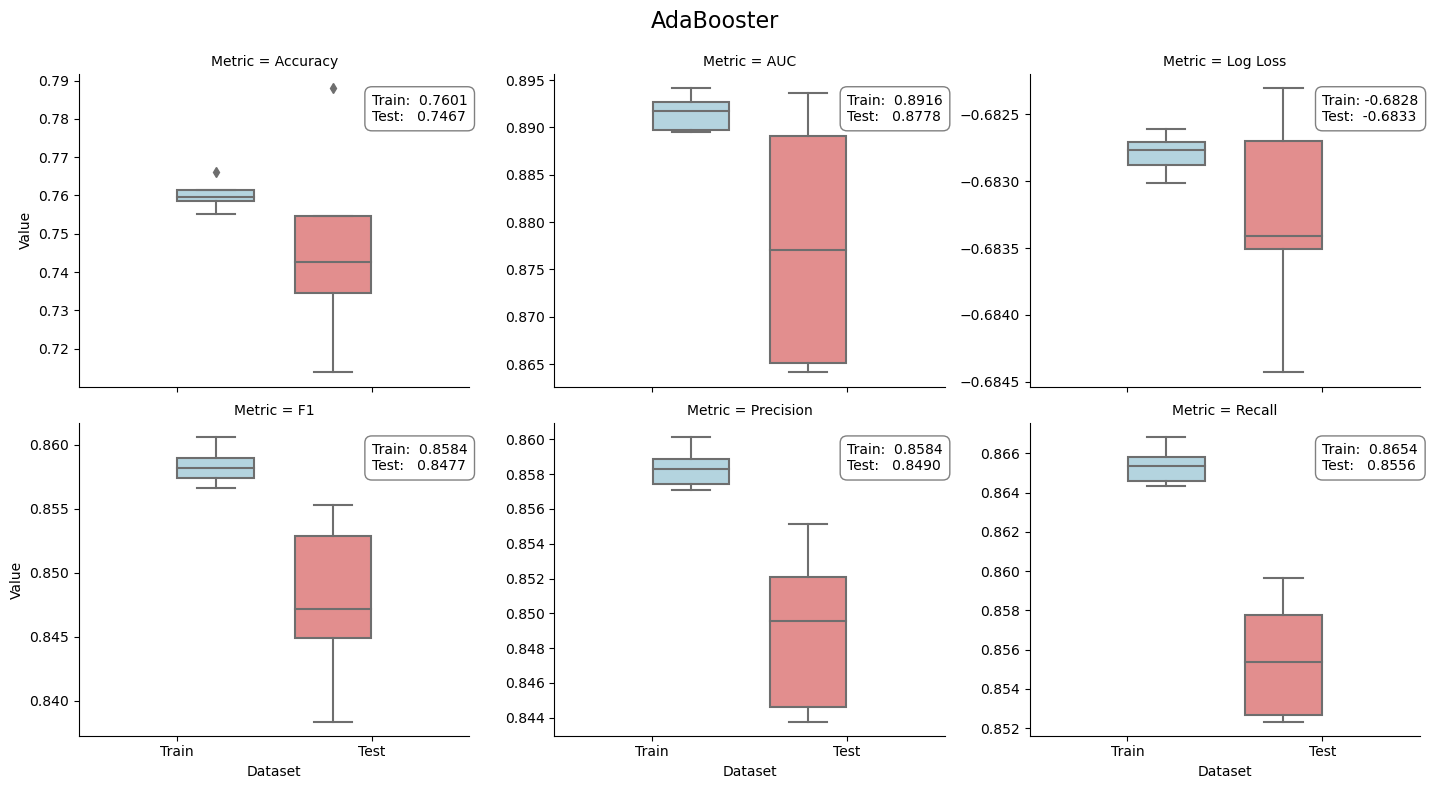

In [6]:
results = utils.run_cross_validation(estimator=ada,
                           X=loandata.features,
                           y=loandata.loan_status,
                           metrics=metrics,
                           cv=5,
                           verbose=False,
                           model='AdaBooster')